# CDAW CME Catalog Analysis Notebook - Properties
This notebook is for analyzing current CDAW CME catalog to look for differences in CMEs.

Want to understand estimated properties of CME events and build a histogram/plots of this 
data.

In [1]:
import requests
import pandas as pd

Need_To_Redownload = False
CME_Catalog_Filename = '../full_cme_event_catalog.csv'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
    
def plot_data (xdata, ydata, xlabel="", ylabel="", title="", alpha=1.0, ylog:bool=False, xlog:bool=False):

    fig, ax = plt.subplots()
    #plt.style.use('fivethirtyeight')
    
    ax.plot(xdata, ydata, 'ro', alpha=alpha)
    ax.set_title(title)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    
    if ylog:
        ax.set_yscale('log')

    if xlog:
        ax.set_xscale('log')
    
    
def plot_hist(data, what, nbins:int=100, ylog:bool=False, xlog:bool=False, xlow:int=0, xhigh:int=None, nofill:bool=False):
    
    fig, ax = plt.subplots()
        
    if nofill:
        data.hist(ax=ax, bins=nbins, bottom=0, fill=None)
    else:
        data.hist(ax=ax, bins=nbins, bottom=0)
    ax.set_title("Histogram")
    ax.set(xlabel=what, ylabel="Num/bin")
    
    if xlow != None and xhigh != None:
        plt.xlim(xlow, xhigh)
    
    #plt.style.use('fivethirtyeight')
    if ylog:
        ax.set_yscale('log')
        
    if xlog:
        ax.set_xscale('log')

In [3]:
# load dataset
c2_c3_data = pd.read_csv(CME_Catalog_Filename)
len(c2_c3_data)

21142

In [4]:
# add datetime column

from datetime import datetime, date, time, timezone, timedelta

def get_datetime(data:pd.DataFrame, date_col:str='date-obs', time_col:str='time-obs')->list:
    # add column of python datetime for easier handling
    datetime_col = []
    for row in data.iterrows():
        date_obs = row[1][date_col]
        time_obs = row[1][time_col]

        date_obs = [int(t) for t in row[1][date_col].split('/')]
        time_obs = [int(t) for t in row[1][time_col].split(':')]

        datetime_col.append(datetime(year=date_obs[0], month=date_obs[1], day=date_obs[2], hour=time_obs[0], minute=time_obs[1], second=time_obs[2]))

    return datetime_col
    
c2_c3_data['datetime'] = get_datetime(c2_c3_data, 'Date', 'Time')
c2_c3_data.index = c2_c3_data.datetime

In [5]:
c2_c3_data[:3]

,Date,Time,Central,Width,Linear,2nd,order,speed,Accel,Mass,...,Duration_C2,Duration_C3,StartTime_C3_Delta,width,linear,mpa,mass,kinetic,accel,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
1996-01-11 00:14:36,1996/01/11,00:14:36,267,18,499,571,426,0,-64.3*,-------,...,8416.833667,36893.787575,3086.172345,18,499,272,0.0,0.0,-64.3,1996-01-11 00:14:36
1996-01-13 22:08:30,1996/01/13,22:08:30,265,16,290,278,303,372,2.8*,-------,...,14482.758621,63482.758621,5310.344828,16,290,266,0.0,0.0,2.8,1996-01-13 22:08:30
1996-01-15 07:01:10,1996/01/15,07:01:10,262,43,525,600,454,0,-31.1,-------,...,8000.000000,35066.666667,2933.333333,43,525,272,0.0,0.0,-31.1,1996-01-15 07:01:10


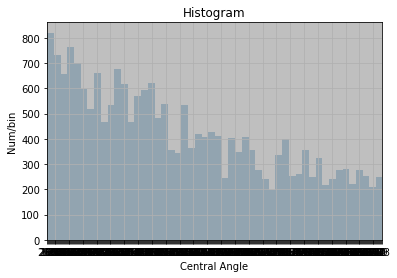

In [6]:
plot_hist(c2_c3_data['Central'], nbins=50, what='Central Angle', ylog=False, xhigh=359)

<ipython-input-25-17b1e1f27bf7>:3: RuntimeWarning: divide by zero encountered in log10
  c2_c3_data['lmass'] = [np.log10(i) for i in c2_c3_data['nmass']]


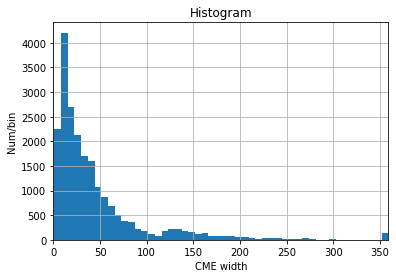

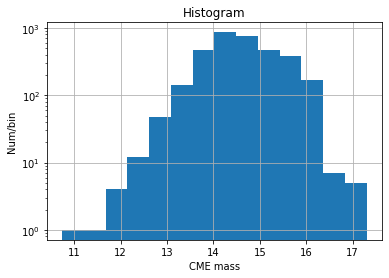

In [25]:
plot_hist(pd.to_numeric(c2_c3_data['Width']), nbins=50, what='CME width', ylog=False, xhigh=359)
c2_c3_data['nmass'] = pd.to_numeric([i.replace('*', '').replace('-','0') for i in c2_c3_data['Mass']])
c2_c3_data['lmass'] = [np.log10(i) for i in c2_c3_data['nmass']]
trimmed = c2_c3_data[c2_c3_data['lmass'] > 10.]
trimmed = trimmed[trimmed['datetime'] < '2006-01-01']
plot_hist(trimmed['lmass'], nbins=14, what='CME mass', ylog=True, xlog=False)

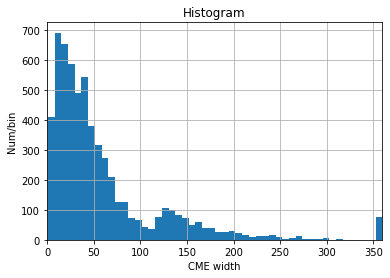

In [8]:
# try to reconstruct the histogram on widths (fig 10, found in gopalswami etal 2009;
#    https://link.springer.com/article/10.1007/s11038-008-9282-7)
# which does NOT show the bump
pre_2007 = c2_c3_data[c2_c3_data['datetime'] < '2007-01-01']
plot_hist(pd.to_numeric(pre_2007['Width']), nbins=50, what='CME width', ylog=False, xhigh=359)

In [9]:
# the gopalswami paper above references ~9000 CMEs between 1996 to 2007, we should have similar number!
# but we dont (the filtered CDAW catalog we have is less than this number; 
# Why? is it because we excluded poor events earlier, and if they were included would it then match??)
len(pre_2007)

5943

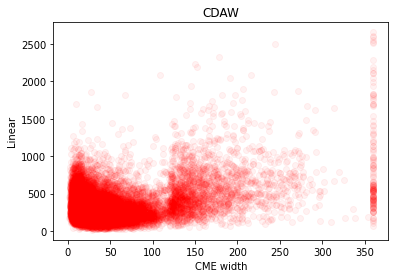

In [10]:
plot_data(pd.to_numeric(c2_c3_data['Width']), pd.to_numeric(c2_c3_data['Linear']), xlabel='CME width', ylabel='Linear', title="CDAW", alpha=0.05)

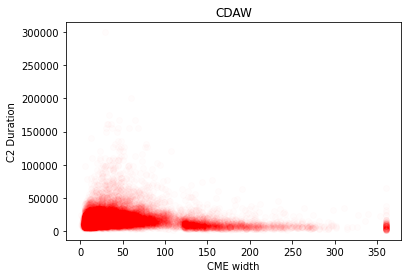

In [11]:
plot_data(pd.to_numeric(c2_c3_data['Width']), pd.to_numeric(c2_c3_data['Duration_C2']), xlabel='CME width', ylabel='C2 Duration', title="CDAW", alpha=0.01)

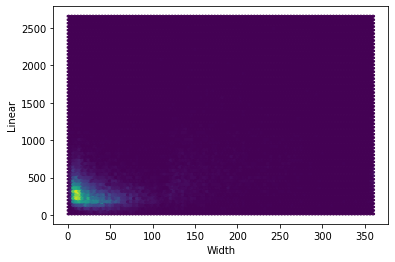

In [12]:
n = 1000 # len(c2_c3_data)
x = pd.to_numeric(c2_c3_data['Width'])
y = pd.to_numeric(c2_c3_data['Linear'])
plt.hexbin(x,y)
plt.xlabel("Width")
plt.ylabel("Linear")
plt.show()

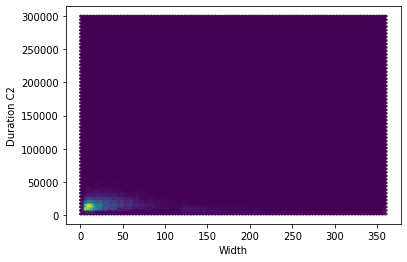

In [13]:
n = 100 # len(c2_c3_data)
x = pd.to_numeric(c2_c3_data['Width'])
y = pd.to_numeric(c2_c3_data['Duration_C2'])
plt.hexbin(x,y)
plt.xlabel("Width")
plt.ylabel("Duration C2")
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=10)
#plt.axis.set_xticks(20)
plt.show()

In [14]:
c2_c3_data

,Date,Time,Central,Width,Linear,2nd,order,speed,Accel,Mass,...,StartTime_C3_Delta,width,linear,mpa,mass,kinetic,accel,datetime,nmass,lmass
datetime,,,,,,,,,,,,,,,,,,,,,
1996-01-11 00:14:36,1996/01/11,00:14:36,267,18,499,571,426,0,-64.3*,-------,...,3086.172345,18,499,272,0.000000e+00,0.000000e+00,-64.3,1996-01-11 00:14:36,0.000000e+00,-inf
1996-01-13 22:08:30,1996/01/13,22:08:30,265,16,290,278,303,372,2.8*,-------,...,5310.344828,16,290,266,0.000000e+00,0.000000e+00,2.8,1996-01-13 22:08:30,0.000000e+00,-inf
1996-01-15 07:01:10,1996/01/15,07:01:10,262,43,525,600,454,0,-31.1,-------,...,2933.333333,43,525,272,0.000000e+00,0.000000e+00,-31.1,1996-01-15 07:01:10,0.000000e+00,-inf
1996-01-22 03:11:01,1996/01/22,03:11:01,105,37,267,401,130,0,-126.3*,7.1e+13*,...,5767.790262,37,267,103,7.100000e+13,2.500000e+28,-126.3,1996-01-22 03:11:01,7.100000e+13,13.851258
1996-01-26 09:16:19,1996/01/26,09:16:19,90,27,262,254,271,322,1.9*,3.0e+14,...,5877.862595,27,262,90,3.000000e+14,1.000000e+29,1.9,1996-01-26 09:16:19,3.000000e+14,14.477121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-29 15:36:05,2020/08/29,15:36:05,284,11,196,227,163,0,-4.8*,-------,...,7857.142857,11,196,282,0.000000e+00,0.000000e+00,-4.8,2020-08-29 15:36:05,0.000000e+00,-inf
2020-08-29 19:48:05,2020/08/29,19:48:05,285,10,218,231,204,79,-2.0*,-------,...,7064.220183,10,218,272,0.000000e+00,0.000000e+00,-2.0,2020-08-29 19:48:05,0.000000e+00,-inf
2020-08-30 01:25:44,2020/08/30,01:25:44,258,42,117,0,213,286,3.5*,-------,...,13162.393162,42,117,250,0.000000e+00,0.000000e+00,3.5,2020-08-30 01:25:44,0.000000e+00,-inf


In [15]:
# pull out SBO group, 50~<Width~<90 from Vourlidas and Webb 2018
sbo_data = c2_c3_data[pd.to_numeric(c2_c3_data['Width']) > 50.]
sbo_data = sbo_data[pd.to_numeric(sbo_data['Width']<90.)]
sbo_data = c2_c3_data

In [16]:
# clean up data, make numeric, get rid of asterisk in columns
sbo_data['width'] = pd.to_numeric(sbo_data['Width'])
#sbo_data['central'] = pd.to_numeric(sbo_data['Central'])
sbo_data['linear'] = pd.to_numeric(sbo_data['Linear'])
sbo_data['mpa'] = pd.to_numeric(sbo_data['MPA'])
#sbo_data['cpa_mpa'] = sbo_data['central'] - sbo_data['mpa']
sbo_data['c2_time'] = pd.to_numeric(sbo_data['Duration_C2'])
sbo_data['mass'] = pd.to_numeric([i.replace('*', '').replace('-','0') for i in sbo_data['Mass']])
sbo_data['kinetic'] = pd.to_numeric([i.replace('*', '').replace('-','0') for i in sbo_data['Kinetic']])
sbo_data['accel'] = pd.to_numeric([i.replace('*', '').replace('--', '0') for i in sbo_data['Accel']])
sbo_data[['accel', 'Accel', 'mass', 'Mass', 'Central', 'kinetic']]

,accel,Accel,mass,Mass,Central,kinetic
datetime,,,,,,
1996-01-11 00:14:36,-64.3,-64.3*,0.000000e+00,-------,267,0.000000e+00
1996-01-13 22:08:30,2.8,2.8*,0.000000e+00,-------,265,0.000000e+00
1996-01-15 07:01:10,-31.1,-31.1,0.000000e+00,-------,262,0.000000e+00
1996-01-22 03:11:01,-126.3,-126.3*,7.100000e+13,7.1e+13*,105,2.500000e+28
1996-01-26 09:16:19,1.9,1.9*,3.000000e+14,3.0e+14,90,1.000000e+29
...,...,...,...,...,...,...
2020-08-29 15:36:05,-4.8,-4.8*,0.000000e+00,-------,284,0.000000e+00
2020-08-29 19:48:05,-2.0,-2.0*,0.000000e+00,-------,285,0.000000e+00
2020-08-30 01:25:44,3.5,3.5*,0.000000e+00,-------,258,0.000000e+00


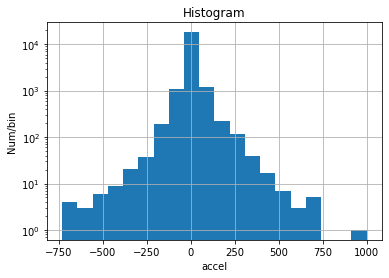

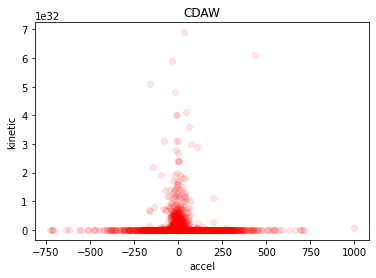

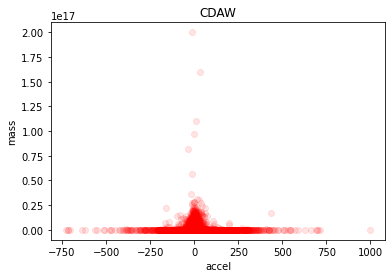

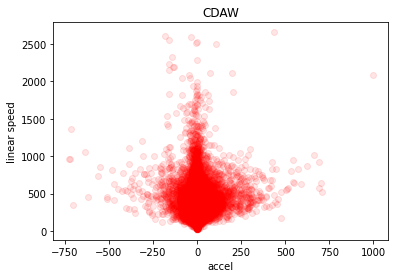

In [17]:
# accel
plot_hist(pd.to_numeric(sbo_data['accel']), nbins=20, what='accel', ylog=True)
plot_data(sbo_data['accel'], sbo_data['kinetic'], ylabel='kinetic', xlabel='accel', title="CDAW", alpha=0.1)
plot_data(sbo_data['accel'], sbo_data['mass'], ylabel='mass', xlabel='accel', title="CDAW", alpha=0.1)
plot_data(sbo_data['accel'], sbo_data['linear'], xlabel='accel', ylabel='linear speed', title="CDAW", alpha=0.1)

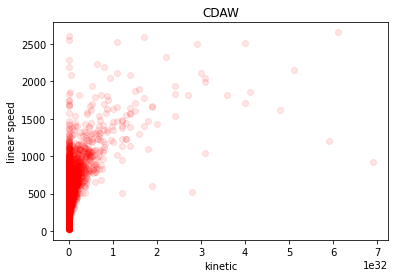

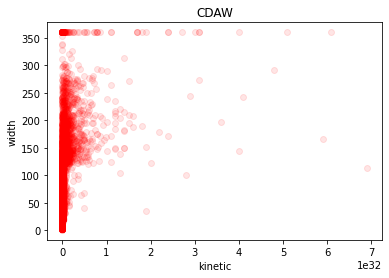

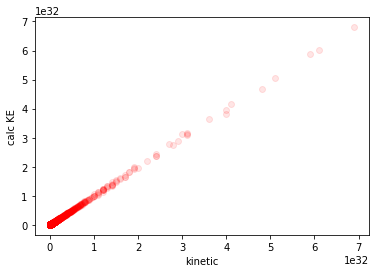

In [18]:
# kinetic
plot_data(sbo_data['kinetic'], sbo_data['linear'], xlabel='kinetic', ylabel='linear speed', title="CDAW", alpha=0.1)
plot_data(sbo_data['kinetic'], sbo_data['width'], xlabel='kinetic', ylabel='width', title="CDAW", alpha=0.1)
plot_data(sbo_data['kinetic'], 0.5*1000000*10000*sbo_data['linear']*sbo_data['linear']*sbo_data['mass'], xlabel='kinetic', ylabel='calc KE', title="", alpha=0.1)

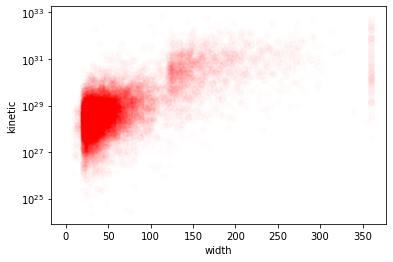

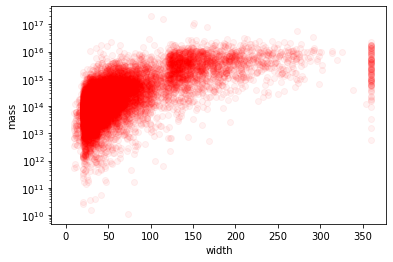

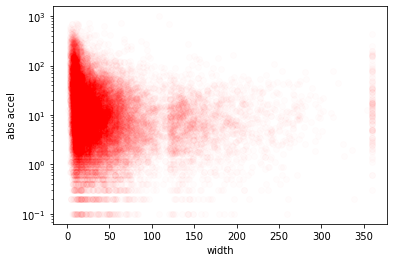

In [19]:
# width
plot_data(sbo_data['width'], sbo_data['kinetic'], ylabel='kinetic', xlabel='width', title="", alpha=0.01, ylog=True)
plot_data(sbo_data['width'], sbo_data['mass'], ylabel='mass', xlabel='width', title="", alpha=0.05, ylog=True)
plot_data(sbo_data['width'], abs(sbo_data['accel']), ylabel='abs accel', xlabel='width', title="", alpha=0.01, ylog=True)

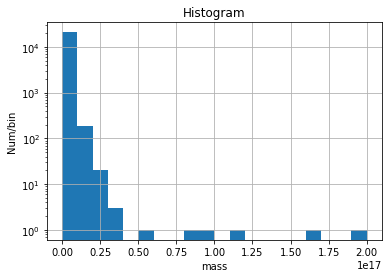

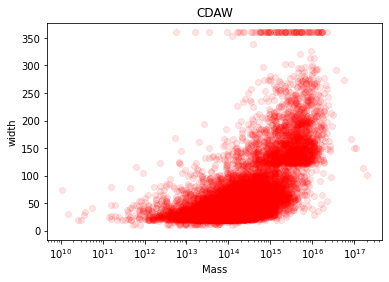

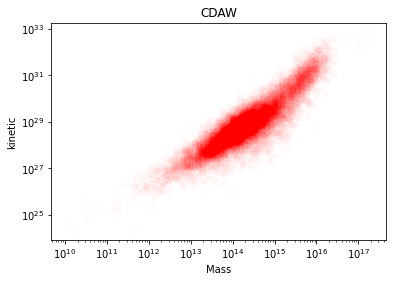

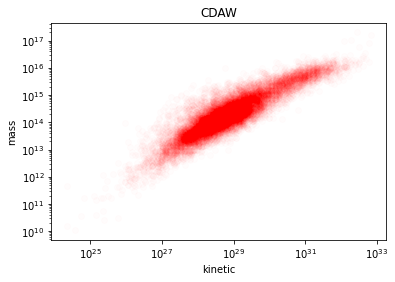

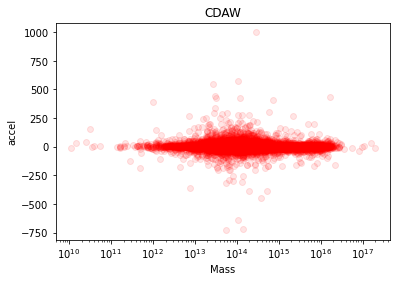

In [20]:
# mass
plot_hist(pd.to_numeric(sbo_data['mass']), nbins=20, what='mass', ylog=True)
plot_data(sbo_data['mass'], sbo_data['width'], ylabel='width', xlabel='Mass', title="CDAW", alpha=0.1, xlog=True)
plot_data(sbo_data['mass'], sbo_data['kinetic'], ylabel='kinetic', xlabel='Mass', title="CDAW", alpha=0.01, ylog=True, xlog=True)
plot_data(sbo_data['kinetic'], sbo_data['mass'], ylabel='mass', xlabel='kinetic', title="CDAW", alpha=0.01, ylog=True, xlog=True)
plot_data(sbo_data['mass'], sbo_data['accel'], ylabel='accel', xlabel='Mass', title="CDAW", alpha=0.1, xlog=True)

In [21]:
# cpa-mpa
#plot_hist(pd.to_numeric(sbo_data['cpa_mpa']), nbins=20, what='CPA - MPA', ylog=True)
#plot_data(sbo_data['kinetic'], sbo_data['cpa_mpa'], xlabel='kinetic', ylabel='CPA-MPA', title="CDAW", alpha=0.1)
#plot_data(sbo_data['kinetic'], abs(sbo_data['cpa_mpa']), xlabel='kinetic', ylabel='Abs(CPA-MPA)', title="CDAW", alpha=0.1, ylog=False)

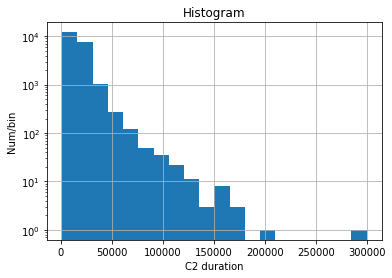

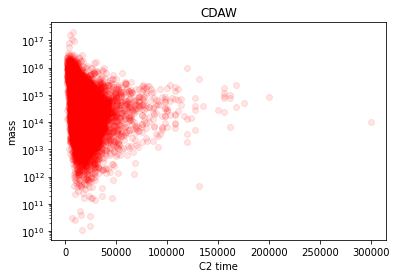

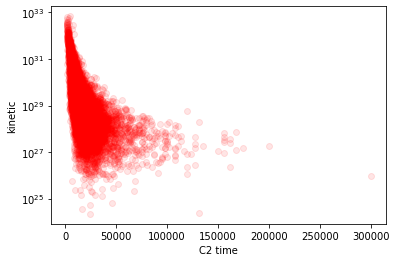

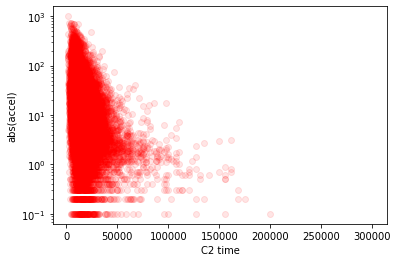

In [22]:
# C2 Duration
plot_hist(sbo_data['c2_time'], nbins=20, what='C2 duration', ylog=True)
plot_data(sbo_data['c2_time'], sbo_data['mass'], ylabel='mass', xlabel='C2 time', title="CDAW", alpha=0.1, ylog=True)
plot_data(sbo_data['c2_time'], sbo_data['kinetic'], ylabel='kinetic', xlabel='C2 time', title="", alpha=0.1, ylog=True)
plot_data(sbo_data['c2_time'], abs(sbo_data['accel']), ylabel='abs(accel)', xlabel='C2 time', title="", alpha=0.1, ylog=True)

In [23]:
c2_c3_data

,Date,Time,Central,Width,Linear,2nd,order,speed,Accel,Mass,...,width,linear,mpa,mass,kinetic,accel,datetime,nmass,lmass,c2_time
datetime,,,,,,,,,,,,,,,,,,,,,
1996-01-11 00:14:36,1996/01/11,00:14:36,267,18,499,571,426,0,-64.3*,-------,...,18,499,272,0.000000e+00,0.000000e+00,-64.3,1996-01-11 00:14:36,0.000000e+00,-inf,8416.833667
1996-01-13 22:08:30,1996/01/13,22:08:30,265,16,290,278,303,372,2.8*,-------,...,16,290,266,0.000000e+00,0.000000e+00,2.8,1996-01-13 22:08:30,0.000000e+00,-inf,14482.758621
1996-01-15 07:01:10,1996/01/15,07:01:10,262,43,525,600,454,0,-31.1,-------,...,43,525,272,0.000000e+00,0.000000e+00,-31.1,1996-01-15 07:01:10,0.000000e+00,-inf,8000.000000
1996-01-22 03:11:01,1996/01/22,03:11:01,105,37,267,401,130,0,-126.3*,7.1e+13*,...,37,267,103,7.100000e+13,2.500000e+28,-126.3,1996-01-22 03:11:01,7.100000e+13,13.851258,15730.337079
1996-01-26 09:16:19,1996/01/26,09:16:19,90,27,262,254,271,322,1.9*,3.0e+14,...,27,262,90,3.000000e+14,1.000000e+29,1.9,1996-01-26 09:16:19,3.000000e+14,14.477121,16030.534351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-29 15:36:05,2020/08/29,15:36:05,284,11,196,227,163,0,-4.8*,-------,...,11,196,282,0.000000e+00,0.000000e+00,-4.8,2020-08-29 15:36:05,0.000000e+00,-inf,21428.571429
2020-08-29 19:48:05,2020/08/29,19:48:05,285,10,218,231,204,79,-2.0*,-------,...,10,218,272,0.000000e+00,0.000000e+00,-2.0,2020-08-29 19:48:05,0.000000e+00,-inf,19266.055046
2020-08-30 01:25:44,2020/08/30,01:25:44,258,42,117,0,213,286,3.5*,-------,...,42,117,250,0.000000e+00,0.000000e+00,3.5,2020-08-30 01:25:44,0.000000e+00,-inf,35897.435897
